In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import random
cv2.ocl.setUseOpenCL(False)
import warnings
warnings.filterwarnings("ignore")


In [2]:
# === STEP 1: Load and Preprocess Images ===
train_img = cv2.imread(r'C:\Users\ronjd\OneDrive\Desktop\project public repo\image stitching\unstitched\train.jpg')
train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)
train_gray = cv2.cvtColor(train_img, cv2.COLOR_RGB2GRAY)



In [3]:
query_img = cv2.imread(r'C:\Users\ronjd\OneDrive\Desktop\project public repo\image stitching\unstitched\query.jpg')
query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
query_gray = cv2.cvtColor(query_img, cv2.COLOR_RGB2GRAY)

In [4]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
ax1.imshow(query_img)
ax1.set_xlabel('Query Image')
ax2.imshow(train_img)
ax2.set_xlabel('Train Image')

Text(0.5, 0, 'Train Image')

In [41]:
#harris corner detection 
def detect_harris_keypoints(gray_img, block_size=2, ksize=3, k=0.04, threshold_ratio=0.01):
    harris_response = cv2.cornerHarris(gray_img, block_size, ksize, k)
    harris_response = cv2.dilate(harris_response, None)
    threshold = threshold_ratio * harris_response.max()
    coords = np.argwhere(harris_response > threshold)
    keypoints = [cv2.KeyPoint(float(x), float(y), 3) for y, x in coords]
    return keypoints


In [42]:
def extract_patch_descriptors(gray_img, keypoints, patch_size):
    half = patch_size // 2
    descriptors = []
    valid_keypoints = []
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        if x - half < 0 or x + half >= gray_img.shape[1] or y - half < 0 or y + half >= gray_img.shape[0]:
            continue
        patch = gray_img[y - half:y + half + 1, x - half:x + half + 1].astype(np.float32)
        patch = patch.flatten()
        patch -= np.mean(patch)
        norm = np.linalg.norm(patch)
        if norm != 0:
            patch /= norm
        descriptors.append(patch)
        valid_keypoints.append(kp)
    return valid_keypoints, np.array(descriptors)

query_kp = detect_harris_keypoints(query_gray)

In [43]:
for patch_size in [9, 11, 13]:
    _, descs = extract_patch_descriptors(query_gray, query_kp, patch_size)
    print(f"Patch size: {patch_size}, descriptors extracted: {descs.shape[0]}")

Patch size: 9, descriptors extracted: 66932
Patch size: 11, descriptors extracted: 66860
Patch size: 13, descriptors extracted: 66775


In [8]:
# === STEP 4: SIFT Descriptor Extraction at Harris Keypoints ===
sift = cv2.SIFT_create()
query_kp = detect_harris_keypoints(query_gray)
train_kp = detect_harris_keypoints(train_gray)
query_kp, query_desc = sift.compute(query_gray, query_kp)
train_kp, train_desc = sift.compute(train_gray, train_kp)

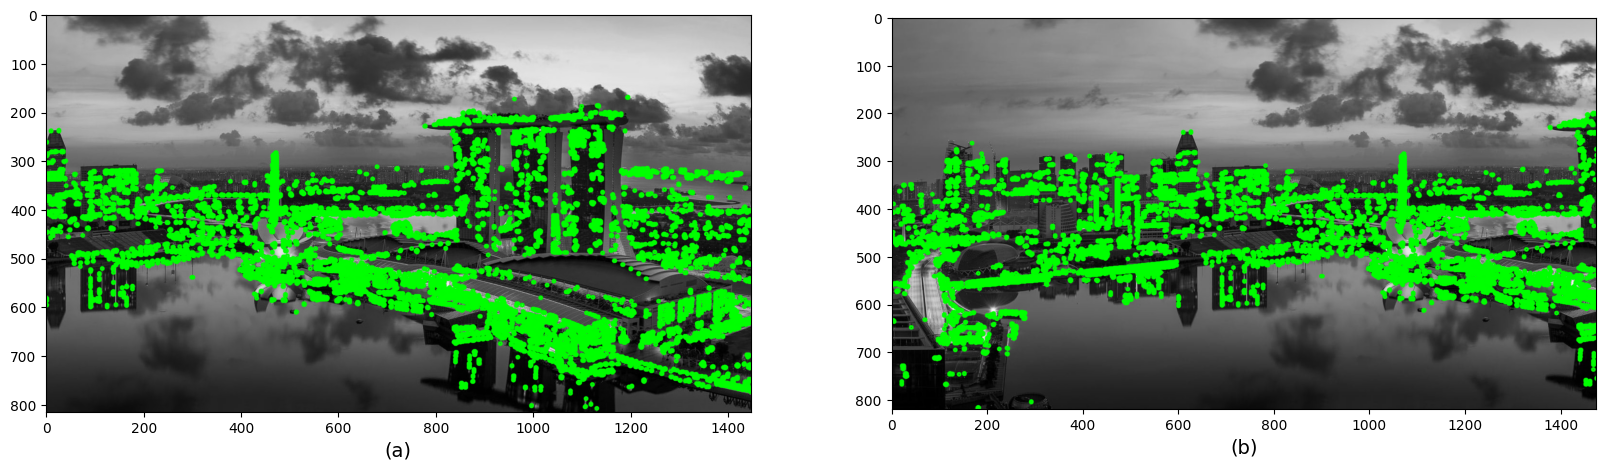

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout = False, figsize=(20, 8))
ax1.imshow(cv2.drawKeypoints(train_gray,    train_kp, None, color=(0, 255, 0)))
ax1.set_xlabel('(a)', fontsize=14)
ax2.imshow(cv2.drawKeypoints(query_gray, query_kp, None, color=(0, 255, 0)))
ax2.set_xlabel('(b)', fontsize=14)

plt.show()

In [10]:
# === STEP 3: Distance Metrics (Manual: Sampled Subset + Sensitivity) ===
def normalize_descriptors(desc):
    norms = np.linalg.norm(desc, axis=1, keepdims=True)
    return desc / (norms + 1e-8)

normalized_query = normalize_descriptors(query_desc)
normalized_train = normalize_descriptors(train_desc)


In [11]:
# Sample descriptors to speed up computation
query_sample_indices = np.random.choice(len(normalized_query), size=min(500, len(normalized_query)), replace=False)
train_sample_indices = np.random.choice(len(normalized_train), size=min(500, len(normalized_train)), replace=False)

In [12]:
#compute the euclidian distnce
matches = []
for i in query_sample_indices:
    dists = np.linalg.norm(normalized_train[train_sample_indices] - normalized_query[i], axis=1)
    best_j_local = np.argmin(dists)
    best_dist = dists[best_j_local]
    best_j = train_sample_indices[best_j_local]
    if best_dist < 0.5:  # Filter for strong matches only
        matches.append(cv2.DMatch(_queryIdx=i, _trainIdx=best_j, _distance=best_dist))


In [13]:
matches = sorted(matches, key=lambda x: x.distance)
matches = matches[:100]
print("total number of matches:", len(matches))

total number of matches: 56


In [37]:
# === STEP 5: Custom RANSAC for Affine Transformation ===
def custom_ransac_affine(matches, kp1, kp2, threshold=3.0, iterations=600):
    best_inliers = []
    best_residuals = []
    best_M = None
    for _ in range(iterations):
        subset = random.sample(matches, 3)
        src_pts = np.float32([kp2[m.trainIdx].pt for m in subset]).reshape(-1, 2)
        dst_pts = np.float32([kp1[m.queryIdx].pt for m in subset]).reshape(-1, 2)
        M = cv2.getAffineTransform(src_pts, dst_pts)

        inliers = []
        residuals = []
        for m in matches:
            pt_train = np.array(kp2[m.trainIdx].pt + (1,))
            predicted = np.dot(M, pt_train)
            actual = np.array(kp1[m.queryIdx].pt)
            error = np.linalg.norm(predicted - actual)
            if error < threshold:
                inliers.append(m)
                residuals.append(error)

        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_M = M
            best_residuals = residuals

    return best_M, best_inliers, best_residuals



In [38]:
M_affine, inlier_matches,residuals = custom_ransac_affine(matches, query_kp, train_kp)
print("Inliers:", len(inlier_matches))
print("Outliers:", len(matches) - len(inlier_matches))
avg_squared_residual = np.mean(np.square(residuals))
rmse = np.sqrt(np.mean(np.square(residuals)))
avg_residual = np.mean(residuals)
print("Average residual:", avg_residual)
print("RMSE:", rmse)
print("Average squared residual:", avg_squared_residual)

Inliers: 33
Outliers: 23
Average residual: 1.7410200005542609
RMSE: 1.9148542155109725
Average squared residual: 3.6666666666601415


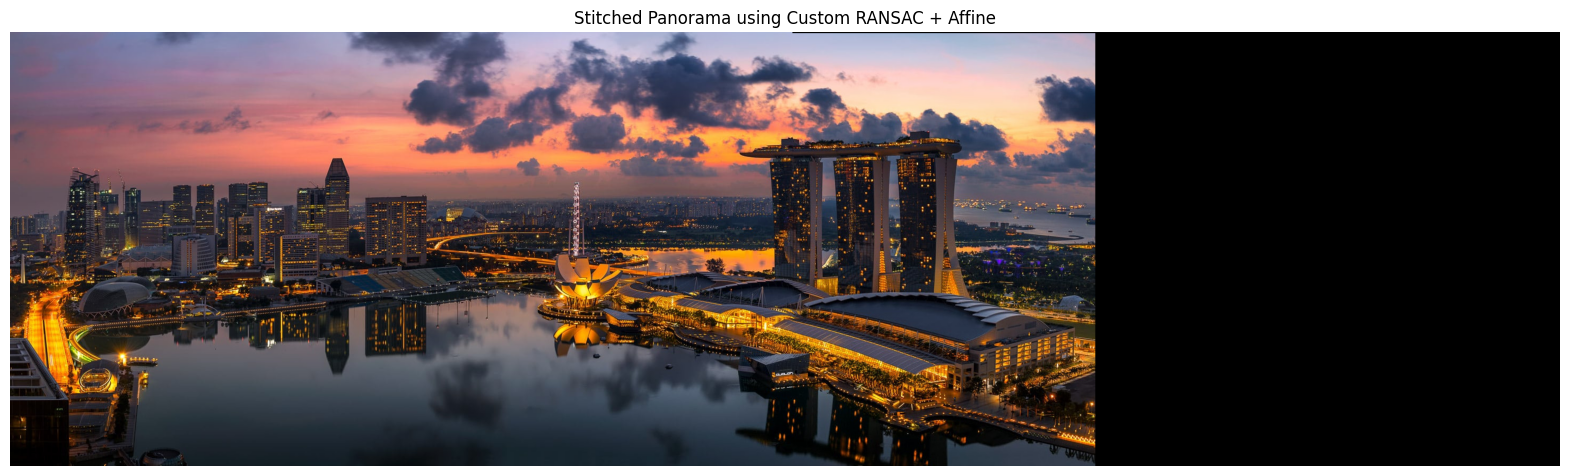

In [39]:
# === STEP 7: Warp Train Image and Stitch ===
height, width = query_img.shape[:2]
warped_img = cv2.warpAffine(train_img, M_affine, (width + train_img.shape[1], height))
warped_img[0:height, 0:width] = query_img

plt.figure(figsize=(20, 8))
plt.imshow(warped_img)
plt.axis('off')
plt.title("Stitched Panorama using Custom RANSAC + Affine")
plt.show()


In [40]:
# === STEP 7: Draw Inlier Matches ===
inlier_vis = cv2.drawMatches(query_img, query_kp, train_img, train_kp, inlier_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20, 8))
plt.imshow(inlier_vis)
plt.axis('off')
plt.title("Inlier Matches")
plt.show()

In [19]:
# === STEP 8: Accuracy Score (Euclidean Distance) ===
def compute_accuracy_score(matches, kp1, kp2, M):
    errors = []
    for m in matches:
        pt_train = np.array(kp2[m.trainIdx].pt + (1,))
        projected = np.dot(M, pt_train)
        target = np.array(kp1[m.queryIdx].pt)
        error = np.linalg.norm(projected - target)
        errors.append(error)
    return np.mean(errors)

accuracy_score = compute_accuracy_score(inlier_matches, query_kp, train_kp, M_affine)
print(f"Accuracy Score (Avg Euclidean Distance): {accuracy_score:.2f} pixels")

Accuracy Score (Avg Euclidean Distance): 1.56 pixels
